In [143]:
using RDatasets, StatsBase, Statistics, DataFrames, LsqFit
using Revise

using CairoMakie
CairoMakie.activate!()
Makie.inline!(true)

import JSON
includet("FunctionData.jl")
data = JSON.parsefile("2023_results.json"); #intake data from json

full_race_points = [25, 18, 15, 12, 10, 8, 6, 4, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] #points awarded for full length races
sprint_race_points = [8, 7, 6, 5, 4, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]; #points awarded for sprint (short) races

In [144]:
#collect all driver numbers used throughout the season
all_driver_nums = FunctionData.get_season_driver_nums(data)

race_df = DataFrame(Driver_Number=all_driver_nums)
for i in 1:length(data)
    race_name = data[i][1]
    race_data = data[i][2]
    positions = []
    ids = []
    missing_drivers = []
    for j in 1:length(race_data)
        #figure out which drivers did not participate in this race
        if data[i][2][20] != nothing
            numbers = map(d->d["driver_number"],data[i][2])
        else
            numbers = map(d->d["driver_number"],data[i][2][1:end-1])
        end
        missing_drivers = FunctionData.list_diff_multi(numbers, all_driver_nums)
        if race_data[j] != nothing
            push!(positions, race_data[j]["position"])
            push!(ids, race_data[j]["driver_number"])
            #race_df.Driver_Number
        end 
    end
    for k in 1:length(missing_drivers)
        push!(positions, missing)
        push!(ids, missing_drivers[k])
    end
    sub_df = DataFrame(Driver_Number=ids, Race_Name=positions)
    rename!(sub_df, ["Driver_Number", data[i][1]])
    race_df = innerjoin(race_df, sub_df, on="Driver_Number")
    #race_df[!, data[i][1]] = sub_df[!, 2]
end

sort!(race_df, "Sakhir:Race")

Row,Driver_Number,Sakhir:Race,Jeddah:Race,Melbourne:Race,Baku:Sprint,Baku:Race,Miami:Race,Monte Carlo:Race,Catalunya:Race,Montreal:Race,Spielberg:Sprint,Spielberg:Race,Silverstone:Race,Hungaroring:Race,Spa-Francorchamps:Sprint,Spa-Francorchamps:Race,Zandvoort:Race,Monza:Race,Singapore:Race,Suzuka:Race,Lusail:Sprint,Lusail:Race,Austin:Sprint,Austin:Race,Mexico City:Race,Interlagos:Sprint,Interlagos:Race,Las Vegas:Race,Yas Marina Circuit:Race
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,1,1,2,1,3,2,1,1,1,1,1,1,1,1,1,1,1,1,5,1,2,1,1,1,1,1,1,1,1
2,11,2,1,5,1,1,2,16,4,6,2,3,6,3,19,2,4,2,8,19,18,10,5,5,20,3,4,3,4
3,14,3,3,3,6,4,3,2,7,2,5,6,7,9,20,5,2,9,15,8,9,6,13,18,18,11,3,9,7
4,55,4,6,12,5,5,5,8,5,5,3,4,10,8,4,19,5,3,1,6,6,20,6,4,4,8,6,6,18
5,44,5,5,2,7,6,6,4,2,3,10,7,3,4,7,4,6,6,3,5,5,19,2,2,2,7,8,7,9
6,18,6,20,4,8,7,12,20,6,9,4,10,14,10,11,9,11,16,missing,18,13,11,20,9,17,12,5,5,10
7,63,7,4,18,4,8,4,5,3,19,8,8,5,6,8,6,17,5,16,7,4,4,8,7,6,4,15,8,3
8,77,8,18,11,16,18,13,11,19,10,20,16,12,12,13,12,15,10,17,20,11,8,16,14,14,19,16,17,19
9,10,9,9,13,13,14,8,7,10,12,15,9,18,20,3,11,3,15,6,10,10,12,7,8,11,13,7,11,13


In [145]:
#filling in the missing data, anyone who did not contest a race is put in 21st place, only 20 cars enter the race.
cleaned_race_df = copy(race_df)
for i in 2:ncol(cleaned_race_df)
    race = cleaned_race_df[!, i]
    for j in 1:length(race)
        if (typeof(race[j]) == Missing)
            race[j] = 21
        end
    end
end
cleaned_race_df;

In [146]:
points_df = copy(cleaned_race_df)
for i in 2:ncol(points_df)
    col = points_df[!, i]
    if split(names(cleaned_race_df)[i], ":")[2] == "Race"
        col = map(x->full_race_points[x], col)
    else
        col = map(x->sprint_race_points[x], col)
    end
    points_df[!, i] = col
end

In [147]:
#creates a table of cumulative points
cul_points_df = points_df
for i in 3:ncol(cul_points_df)
    col = cul_points_df[!, i]
    col_prev = cul_points_df[!, i - 1]
    col = col.+col_prev
    points_df[!, i] = col
end

In [148]:
sort(cul_points_df, :"Yas Marina Circuit:Race", rev=true);
sort!(race_df, :"Yas Marina Circuit:Race");

In [149]:
fig = Figure()
ax = Axis(fig[1,1], aspect = 1, limits = (0, 30, 1, 600), title="Culmulative Points Scored", xlabel="Race Number", ylabel="Points Total")
ver = Array(cul_points_df[1, :][2:end])
per = Array(cul_points_df[2, :][2:end])
lines!(1:length(ver), ver, label="Verstappen")
lines!(1:length(ver), per, label="Perez")
Legend(fig[1,2], ax)
fig;

In [150]:
fig = Figure()
ax = Axis(fig[1,1], aspect = 1, limits = (1, 600, 1, 300))
ver = Array(cul_points_df[1, :][2:end])
per = Array(cul_points_df[2, :][2:end])
lines!(ver, per)
fig;

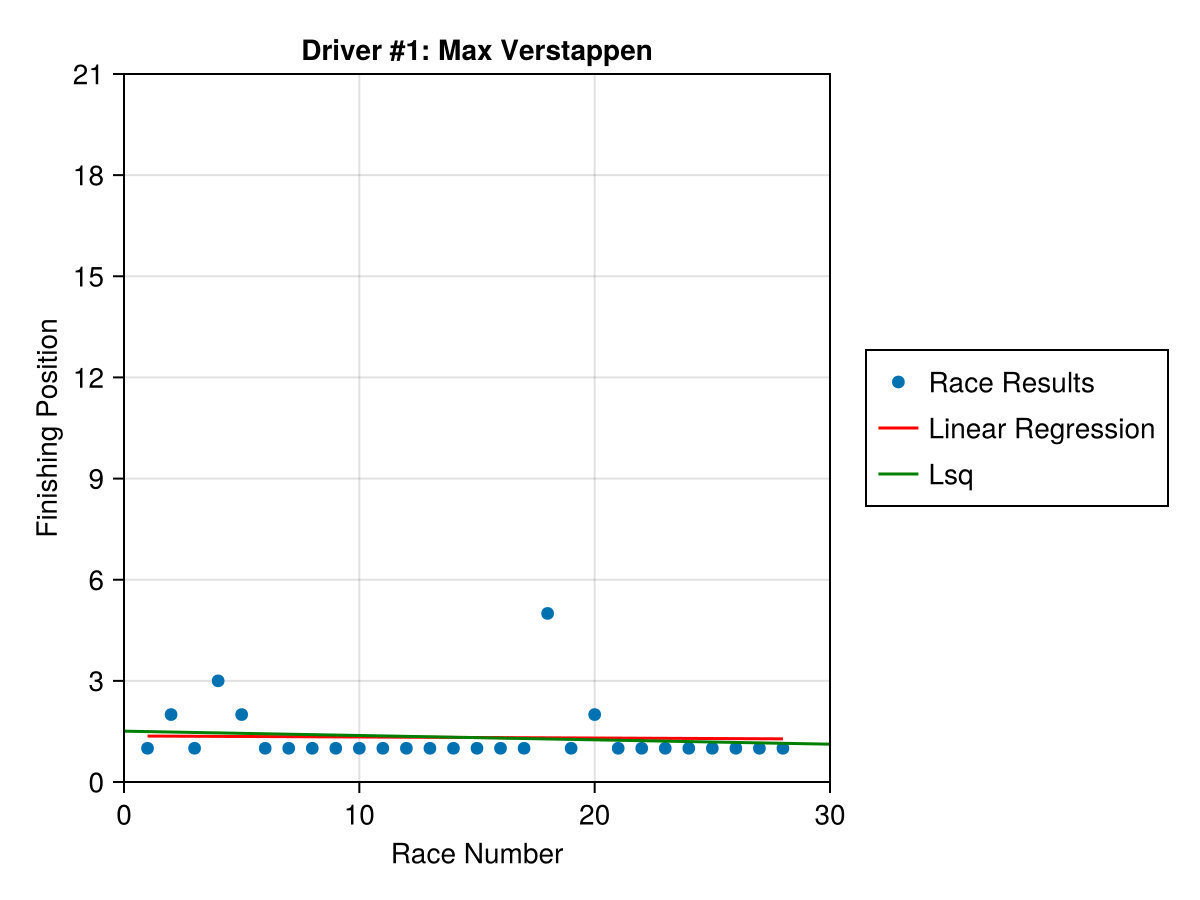

In [151]:
FunctionData.createDualGraph(race_df, 1, "Max Verstappen")

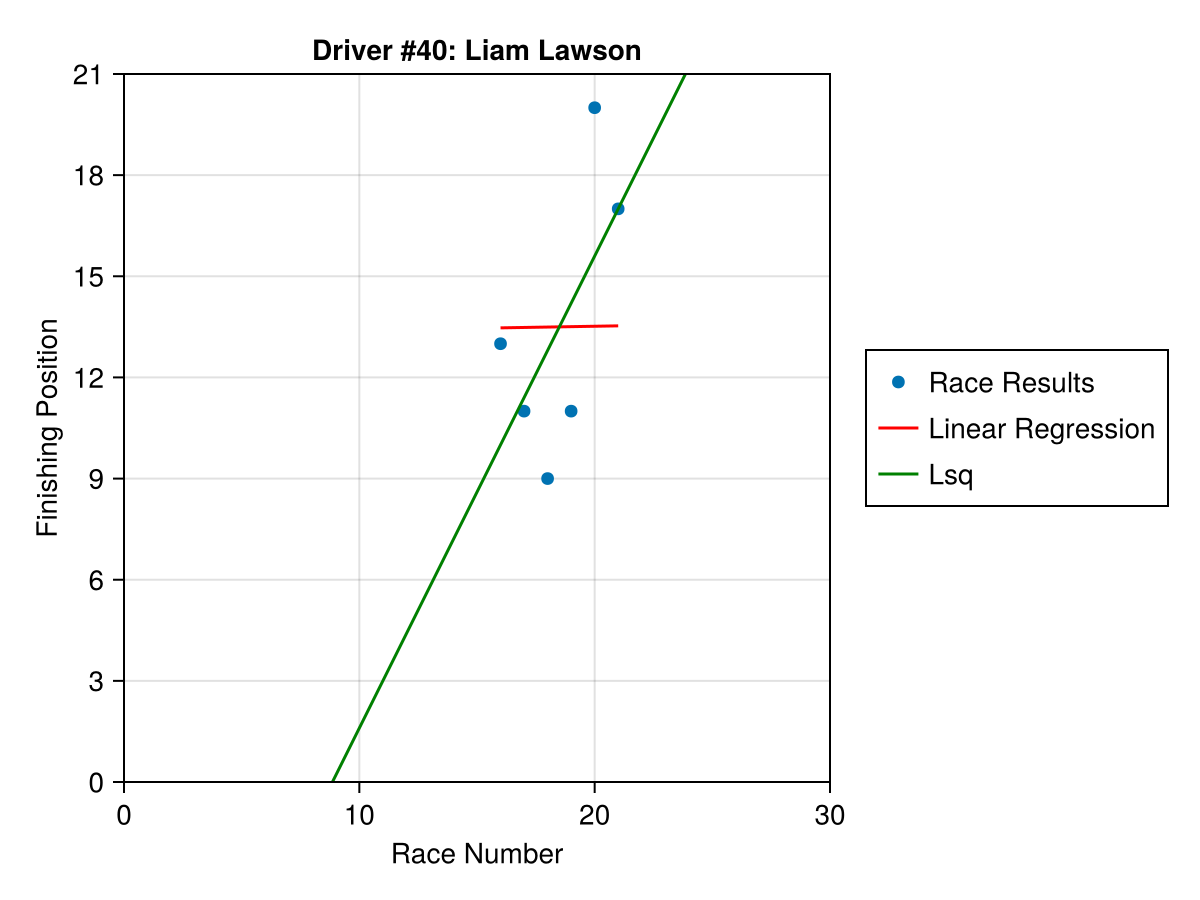

In [152]:
FunctionData.createDualGraph(race_df, 22, "Liam Lawson")

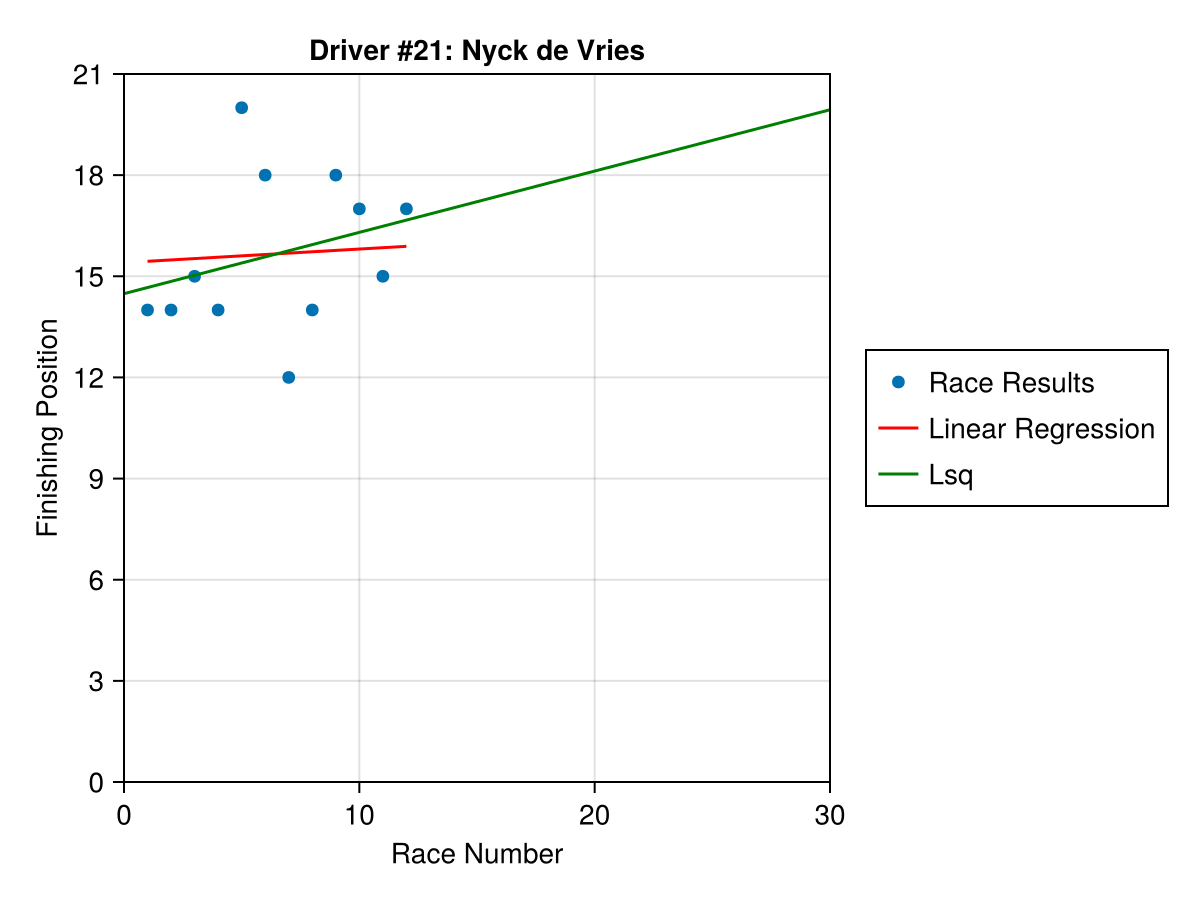

In [153]:
FunctionData.createDualGraph(race_df, 21, "Nyck de Vries")

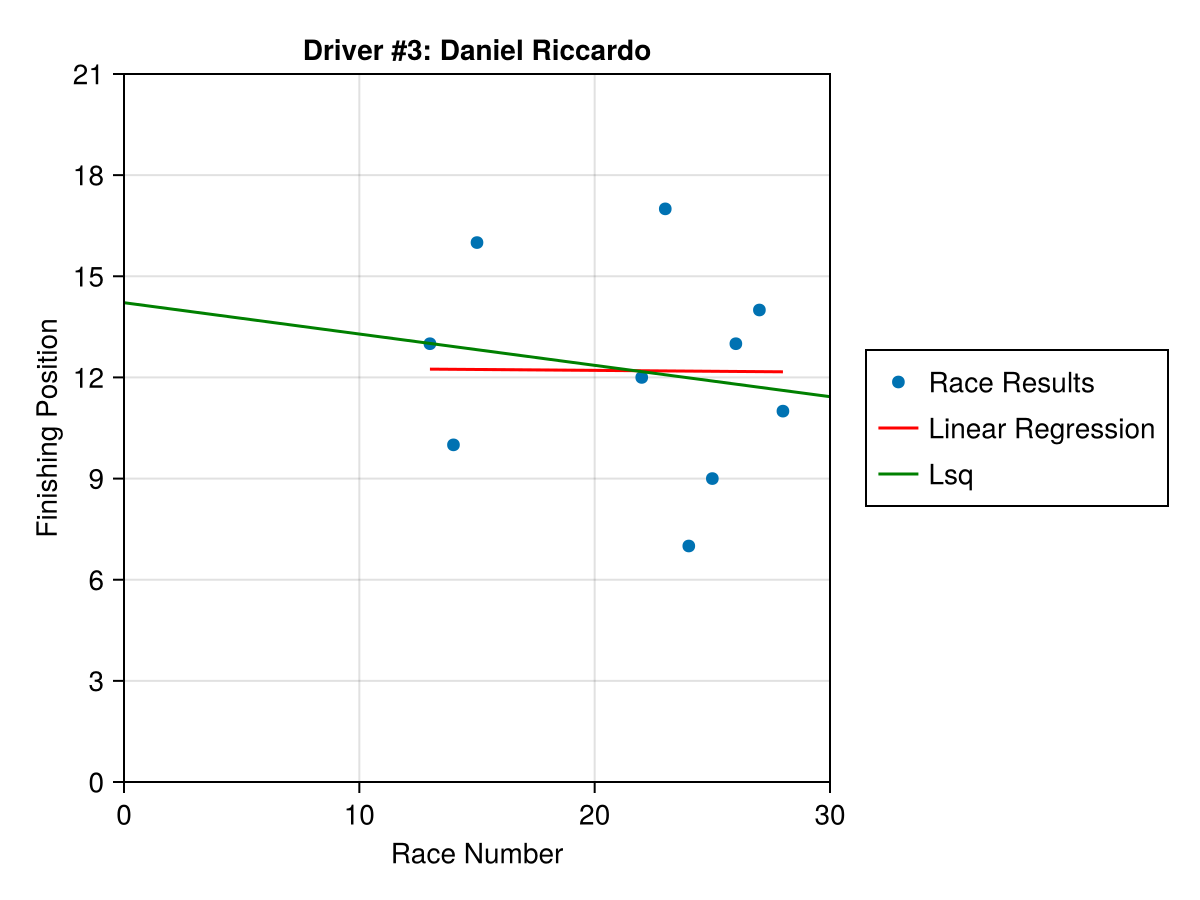

In [154]:
FunctionData.createDualGraph(race_df, 11, "Daniel Riccardo")

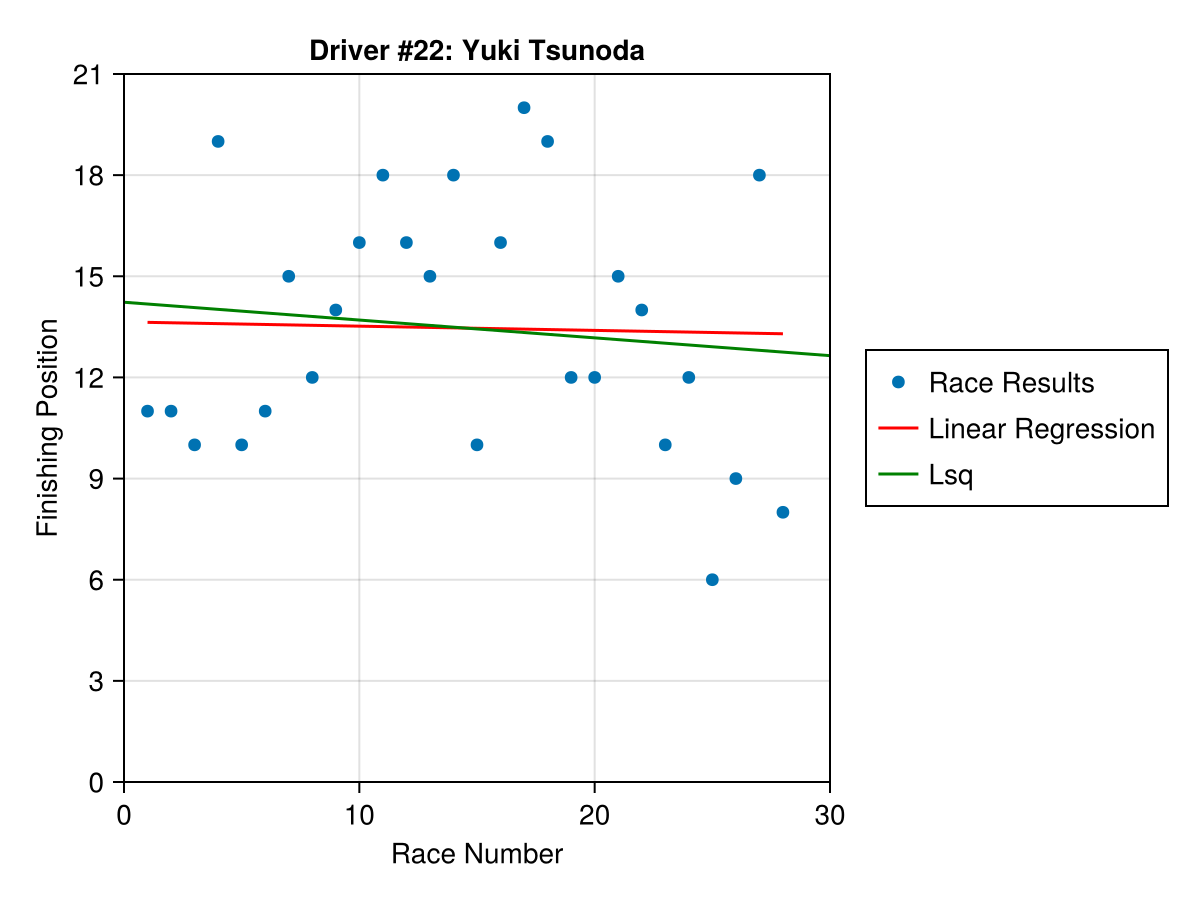

In [155]:
FunctionData.createDualGraph(race_df, 8, "Yuki Tsunoda")

In [156]:
standings_num = 20
driver = FunctionData.dropmissing(Array(race_df[standings_num, :][2:end]))
test = FunctionData.XYData(collect(1:length(driver)), driver)
FunctionData.bestFitLine(test)

(a, b) = (0.030131826741996232, 14.991659940812482)


DimensionMismatch: DimensionMismatch: gradient(f, x) expects that f(x) is a real number. Perhaps you meant jacobian(f, x)?